Updated: 17/01/24

The purpose of this workbook is to demonstrate how spatial reconstruction can be used to calculate the spin of a black hole.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfitsrd as qnmfits
from multiprocessing import Pool
from spatial_reconstruction import *
from matplotlib.animation import FuncAnimation
from scipy.interpolate import UnivariateSpline

l_max = 4
n_max = 4

sim = qnmfits.SXS(ID=305, zero_time=(2,2))

/data/rvnd2/python_envs/python-3.11-clone/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [2]:
mapping = [(2,2,0,1)]

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

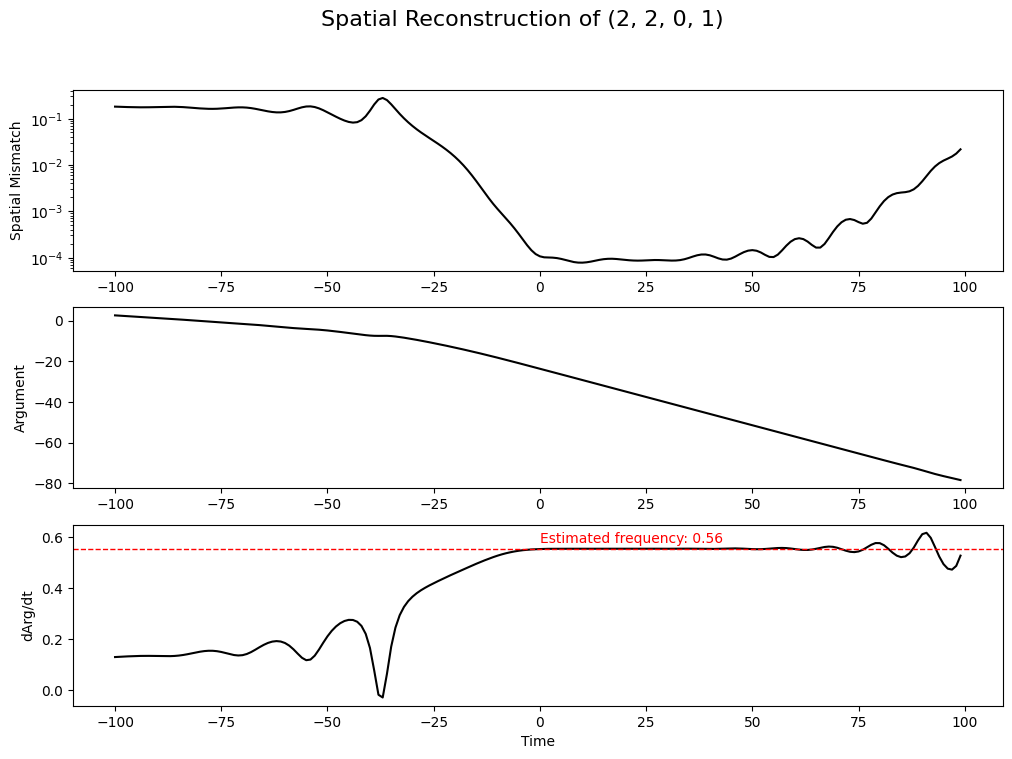

In [4]:
tstart = -100
tend = 100
tstep = 1

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)
Lon, Lat = np.meshgrid(lon, lat)

sm_list = []
arg_list = []
times_list = np.arange(tstart, tend, tstep)

map = mapping[0]

G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

for step in times_list:
    best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                                sim.h, 
                                                modes=QNMs,
                                                Mf=sim.Mf,
                                                chif=sim.chif_mag,
                                                t0=step,
                                                mapping_modes=mapping,
                                                spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                                for m in np.arange(-l,l+1)])

    F = mode_mapping(np.pi/2-Lat, Lon, best_fit, map, l_max)
    sm, arg, _ = spatial_mismatch(F, G, num_points=100)
    sm_list.append(sm)
    arg_list.append(arg)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,8))

fig.suptitle(f'Spatial Reconstruction of {map}', fontsize=16)

axs[0].title.set_position([0.5, 1.05])  
axs[0].plot(times_list, sm_list, color='black')
axs[0].set_yscale('log')
axs[0].set_ylabel('Spatial Mismatch')

axs[1].title.set_position([0.5, 1.05])  
axs[1].plot(times_list, np.unwrap(arg_list), color='black')
axs[1].set_ylabel('Argument')

uvsarg = UnivariateSpline(times_list, -np.unwrap(arg_list), k=4, s=0)
axs[2].plot(times_list, uvsarg.derivative()(times_list), color='black')
f_estimate = np.mean(uvsarg.derivative()(times_list[(times_list >= 0) & (times_list <= 50)]))
axs[2].axhline(f_estimate, color='r', ls='--', lw=1)
axs[2].text(0, f_estimate + 0.01, f'Estimated frequency: {f_estimate:.2f}', color='r', ha='left', va='bottom')
axs[2].set_ylabel('dArg/dt')

plt.xlabel('Time')
plt.show()


In [7]:
print(sim.Mf)
print(f_estimate)

0.952032939704
0.5557225107852556


Note that the mapping 'kicks in' at ~0 through to ~50. Hence, average the frequency across this time period. 

To calculate the spin without explicitly providing it, calculate spatial mismatch at t=25 for a variety of spins and masses (actually, spin is given via the predicted spatial map which uses mu and is used to calculate spatial mismatch). 

In [21]:
from tqdm import tqdm

Mf_minmax = [sim.Mf-0.1, sim.Mf+0.1]
chif_minmax = [sim.chif_mag-0.1, sim.chif_mag+0.1]
res = 50

Mf_array = np.linspace(Mf_minmax[0], Mf_minmax[1], res)
chif_array = np.linspace(chif_minmax[0], chif_minmax[1], res)

sm_list = []

G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

for i in tqdm(range(len(Mf_array)*len(chif_array))):

    Mf = Mf_array[int(i/len(Mf_array))]
    chif = chif_array[i%len(chif_array)]

    best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                            sim.h, 
                                            modes=QNMs,
                                            Mf=Mf,
                                            chif=chif,
                                            t0=25,
                                            mapping_modes=mapping,
                                            spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                            for m in np.arange(-l,l+1)])

    F = mode_mapping(np.pi/2-Lat, Lon, best_fit, map, l_max)
    sm, arg, _ = spatial_mismatch(F, G, num_points=100)
    sm_list.append(sm)


100%|██████████| 2500/2500 [32:04<00:00,  1.30it/s]


********** SUMMARY **********
Actual final mass: 0.952032939704
Actual final spin: 0.6920851868180025
Actual QNM frequency: 0.5557819110480493
Reconstructed QNM frequency: 0.5557201388252119
Reconstructed mass and spin:


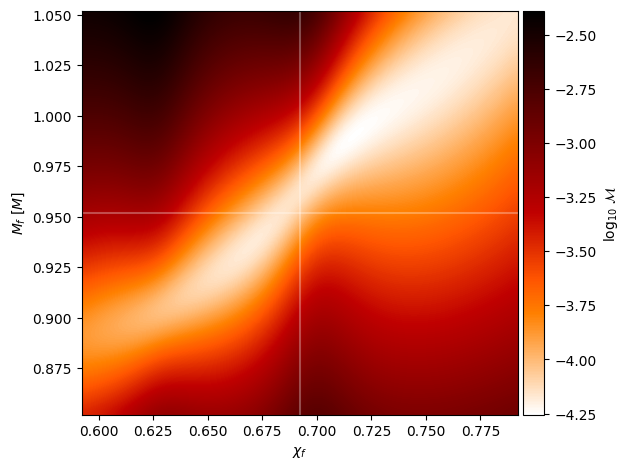

In [27]:
sm_grid = np.reshape(
    np.array(sm_list), (len(Mf_array), len(chif_array)))

qnmfits.plot_mismatch_M_chi_grid(
    sm_grid,
    Mf_minmax,
    chif_minmax,
    truth=[sim.Mf,sim.chif_mag],
    fig_kw={'dpi':100}
)

l,m,n,p = map 

print('********** SUMMARY **********')
print(f'Actual final mass: {sim.Mf}')
print(f'Actual final spin: {sim.chif_mag}')
print(f'Actual QNM frequency: {qnmfits.qnm.omega(l,m,n,p,sim.chif_mag, Mf=sim.Mf).real}')
print(f'Reconstructed QNM frequency: {f_estimate}')
print('Reconstructed mass and spin:')

This only uses the spatial mismatch of one QNM mapping (2,2,0,1) to obtain a Mass/Spin estimate. With a suitable definition of overall spatial mismatch, presumably the accuracy of this estimate will improve (however this would take considerably longer to run). 